#1.&nbsp;Preparing the Environment

##1.1 Downloading Prerequisites

In [ ]:
import numpy as np
import pandas as pd
import cv2
import keras
from numpy import random
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import shutil

In [ ]:
import zipfile
import os
from google.colab import files

##1.2. Set Seed for Random Number Generation

In [ ]:
'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

##1.3 Load Dataset from Kaggle to Goggle Colab

In [ ]:
! pip install -q kaggle

**Download your Kaggle.json token from Account/API Create New Token (As Shown)** <br> **Then, Upload it from the next cell**

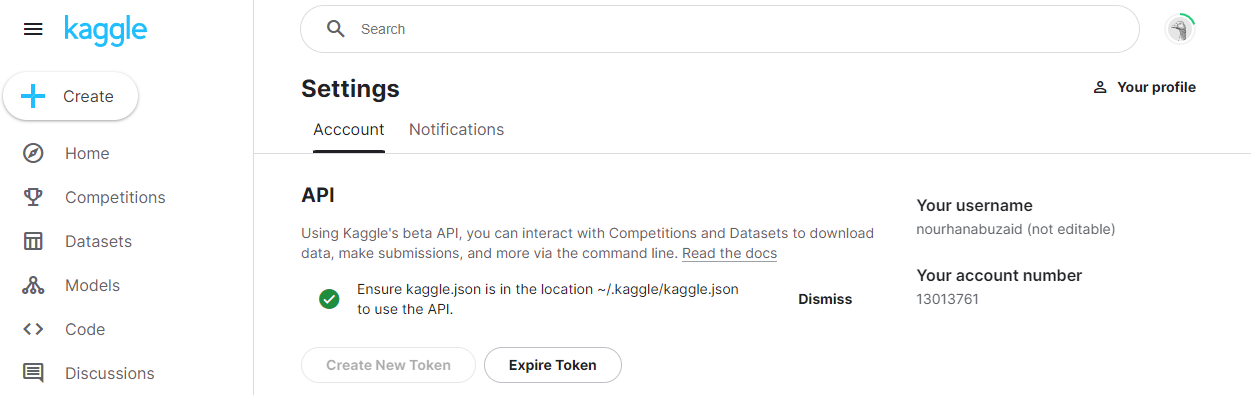

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nourhanabuzaid","key":"1f894da1acf589314b845e45a0c215b2"}'}

In [ ]:
#Make directory name kaggle
! mkdir ~/.kaggle
#Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

#Downloading dataset not part from any competition
! kaggle datasets download mohamedhanyyy/chest-ctscan-images

 94% 111M/119M [00:00<00:00, 152MB/s] 
100% 119M/119M [00:00<00:00, 133MB/s]


In [ ]:
# Specify the path to your zip file
zip_file_path = '/content/chest-ctscan-images.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall()

print("Extraction complete!")

Extraction complete!


#2.&nbsp;Data Exploration & Analysis

##2.1. Define Data Paths & Subdirectories

In [ ]:
TRAIN_DIR_PATH = '/content/Data/train'
VALID_DIR_PATH = '/content/Data/valid'
TEST_DIR_PATH = '/content/Data/test'

In [ ]:
subdirectories = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
                  'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
                  'normal',
                  'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [ ]:
subdirectories_test = ['adenocarcinoma',
                  'large.cell.carcinoma',
                  'normal',
                  'squamous.cell.carcinoma']

##2.2. Count the Images of each label

In [ ]:
#Count All the images in the train folder
for subdirectory in subdirectories:
    folder_path = os.path.join(TRAIN_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)
    print('Folder "{}" has {} number of images.'.format(subdirectory, len(file_names)))

Folder "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib" has 195 number of images.
Folder "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa" has 115 number of images.
Folder "normal" has 148 number of images.
Folder "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa" has 155 number of images.


In [ ]:
#Count All the images in the valid folder
for subdirectory in subdirectories:
    folder_path = os.path.join(VALID_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)
    print('Folder "{}" has {} number of images.'.format(subdirectory, len(file_names)))

Folder "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib" has 23 number of images.
Folder "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa" has 21 number of images.
Folder "normal" has 13 number of images.
Folder "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa" has 15 number of images.


In [ ]:
#Count All the images in the test folder
for subdirectory in subdirectories_test:
    folder_path = os.path.join(TEST_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)
    print('Folder "{}" has {} number of images.'.format(subdirectory, len(file_names)))

Folder "adenocarcinoma" has 120 number of images.
Folder "large.cell.carcinoma" has 51 number of images.
Folder "normal" has 54 number of images.
Folder "squamous.cell.carcinoma" has 90 number of images.


##2.3. Create a Dataframe of the data
3 Dataframes for (Train, Test and Valid) <br>
Each Dataframe has 2 attributrs: (filename, label)

In [ ]:
train_data = {'filename': [], 'label': []}

for label, subdirectory in enumerate(subdirectories):
    folder_path = os.path.join(TRAIN_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        train_data['filename'].append(file_name)
        train_data['label'].append(label)

df_train = pd.DataFrame(train_data)
df_train['label'] = df_train['label'].map({
    0: 'Adenocarcinoma',
    1: 'Large cell carcinoma',
    2: 'Normal',
    3: 'Squamous cell carcinoma'
})

# Display the resulting DataFrame
df_train.head()

,filename,label
0,ad3.png,Adenocarcinoma
1,000099 (7).png,Adenocarcinoma
2,000054 (6).png,Adenocarcinoma
3,000059 (7).png,Adenocarcinoma
4,000055 (2).png,Adenocarcinoma


In [ ]:
valid_data = {'filename': [], 'label': []}

for label, subdirectory in enumerate(subdirectories):
    folder_path = os.path.join(VALID_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        valid_data['filename'].append(file_name)
        valid_data['label'].append(label)

df_valid = pd.DataFrame(valid_data)
df_valid['label'] = df_valid['label'].map({
    0: 'Adenocarcinoma',
    1: 'Large cell carcinoma',
    2: 'Normal',
    3: 'Squamous cell carcinoma'
})

# Display the resulting DataFrame
df_valid.head()

,filename,label
0,000109 (8).png,Adenocarcinoma
1,000115 (5).png,Adenocarcinoma
2,000109 (3).png,Adenocarcinoma
3,000111 (2).png,Adenocarcinoma
4,000115.png,Adenocarcinoma


In [ ]:
test_data = {'filename': [], 'label': []}

for label, subdirectory in enumerate(subdirectories_test):
    folder_path = os.path.join(TEST_DIR_PATH, subdirectory)
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        test_data['filename'].append(file_name)
        test_data['label'].append(label)

df_test = pd.DataFrame(test_data)
df_test['label'] = df_test['label'].map({
    0: 'Adenocarcinoma',
    1: 'Large cell carcinoma',
    2: 'Normal',
    3: 'Squamous cell carcinoma'
})

# Display the resulting DataFrame
df_test.head()

,filename,label
0,000155 (4).png,Adenocarcinoma
1,000163 (3).png,Adenocarcinoma
2,000135 (5).png,Adenocarcinoma
3,000148 (3).png,Adenocarcinoma
4,000121 (6).png,Adenocarcinoma


In [ ]:
print('Number of Total Training Images:',df_train.shape[0])
print('Number of Total Validation Images:',df_valid.shape[0])
print('Number of Total Testing Images:',df_test.shape[0])

Number of Total Training Images: 613
Number of Total Validation Images: 72
Number of Total Testing Images: 315


##2.4. Plot Dataset Label Distribution

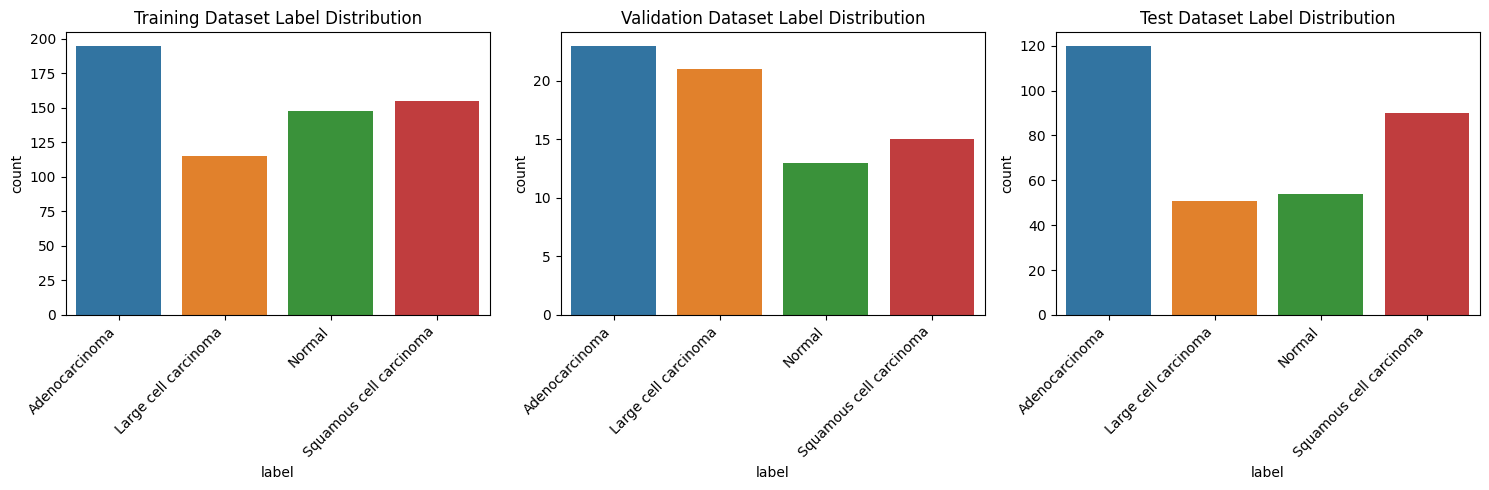

In [ ]:
# Plot for df_train
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=df_train['label'])
plt.title('Training Dataset Label Distribution')
plt.xticks(rotation=45, ha='right')

# Plot for df_valid
plt.subplot(1, 3, 2)
sns.countplot(x=df_valid['label'])
plt.title('Validation Dataset Label Distribution')
plt.xticks(rotation=45, ha='right')

# Plot for df_test
plt.subplot(1, 3, 3)
sns.countplot(x=df_test['label'])
plt.title('Test Dataset Label Distribution')
plt.xticks(rotation=45, ha='right')

# Adjust layout for better display
plt.tight_layout()

# Show the plots
plt.show()

##2.5. Show Random Samples from the Data

In [ ]:
# Create empty lists for each label
adenocarcinoma = []
large_cell_carcinoma = []
normal = []
squamous_cell_carcinoma = []

# Iterate over rows in the DataFrame and append filenames to respective lists
for index, row in df_train.iterrows():
    filename = row['filename']
    label = row['label']

    if label == 'Adenocarcinoma':
        adenocarcinoma.append(filename)
    elif label == 'Large cell carcinoma':
        large_cell_carcinoma.append(filename)
    elif label == 'Normal':
        normal.append(filename)
    elif label == 'Squamous cell carcinoma':
        squamous_cell_carcinoma.append(filename)

ValueError: ignored

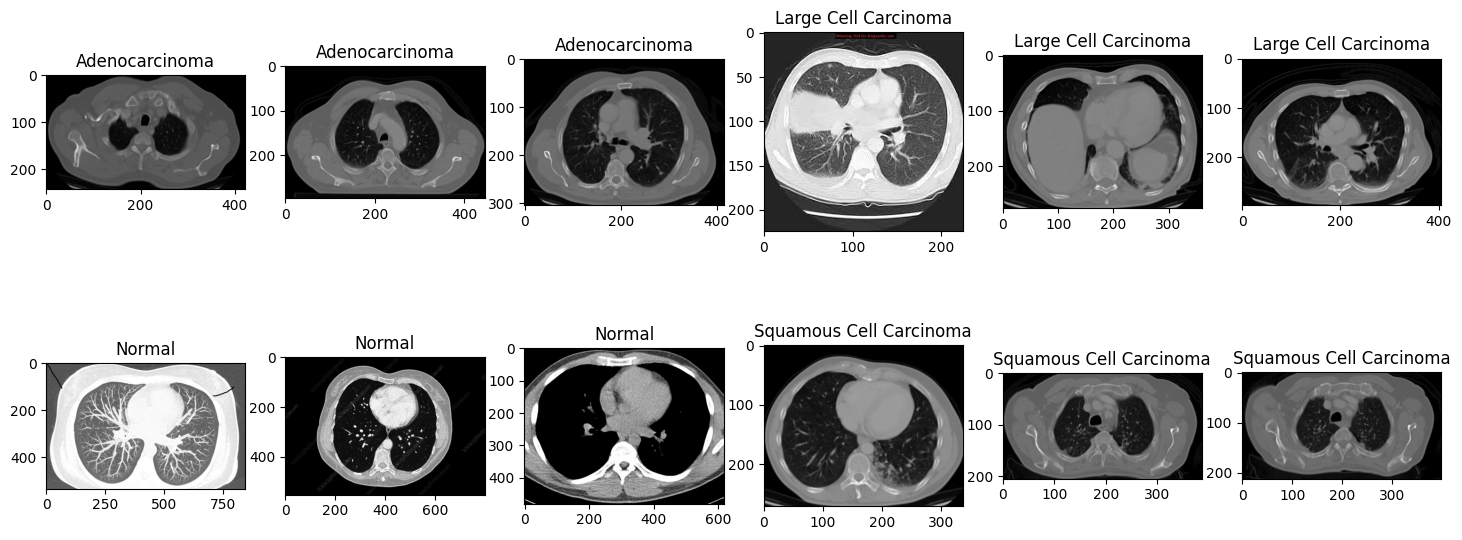

In [ ]:
# Generate a 2x6 grid
plt.figure(figsize=(18, 7))

# Display random images from the 'adenocarcinoma' category
for i, c in enumerate(np.random.randint(0, len(adenocarcinoma), 6), start=1):
    im = img.imread('/content/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/' + adenocarcinoma[c])
    plt.subplot(2, 6, i)
    plt.imshow(im)
    plt.title('Adenocarcinoma')  # Add label as title

# Display random images from the 'large_cell_carcinoma' category
for i, c in enumerate(np.random.randint(0, len(large_cell_carcinoma), 6), start=4):
    im = img.imread('/content/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/' + large_cell_carcinoma[c])
    plt.subplot(2, 6, i)
    plt.imshow(im)
    plt.title('Large Cell Carcinoma')  # Add label as title

# Display random images from the 'normal' category
for i, c in enumerate(np.random.randint(0, len(normal), 6), start=7):
    im = img.imread('/content/Data/train/normal/' + normal[c])
    plt.subplot(2, 6, i)
    plt.imshow(im)
    plt.title('Normal')  # Add label as title

# Display random images from the 'squamous_cell_carcinoma' category
for i, c in enumerate(np.random.randint(0, len(squamous_cell_carcinoma), 6), start=10):
    im = img.imread(
        '/content/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/' + squamous_cell_carcinoma[c])
    plt.subplot(2, 6, i)
    plt.imshow(im)
    plt.title('Squamous Cell Carcinoma')  # Add label as title

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

##2.6. PCA

In [ ]:
def load_and_sharpen_images_from_subdirectories(parent_directory, subdirectories, target_size=(224, 224)):
    images = []
    labels = []  # Store corresponding labels
    for subdir in subdirectories:
        subdir_path = os.path.join(parent_directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            image_path = os.path.join(subdir_path, file)
            if os.path.isfile(image_path):
                # Read image in grayscale
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
                if image is not None:

                    # Convert grayscale to RGB by replicating the single channel to three channels
                    image_rgb = cv.merge((image, image, image))

                    # Resize to target size
                    image_resized = cv.resize(image_rgb, target_size)
                    # print(image_resized.shape)
                    images.append(image_resized)

                    # Assign label based on directory name
                    if subdir == 'normal':
                        labels.append([1, 0])  # Non-cancerous label (1, 0) for one-hot encoding
                    else:
                        labels.append([0, 1])  # Cancerous label (0, 1) for one-hot encoding
    print(images[0].shape)

    return np.array(images), np.array(labels)

In [ ]:
train_images,train_labels = load_and_sharpen_images_from_subdirectories(train_dir, subdirectories)
valid_images,valied_labels = load_and_sharpen_images_from_subdirectories(valid_dir, subdirectories)
test_images,test_labels = load_and_sharpen_images_from_subdirectories(test_dir, ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

In [ ]:
pca = PCA(n_components=None)  # Set 'n_components' to 'None' to calculate all components

# Fit PCA to the data
pca.fit(df)

# Get explained variances
explained_variance = pca.explained_variance_ratio_
#########################################################################

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()
#################################################################################
cumulative_variance = np.cumsum(explained_variance)
threshold = 0.95  # Set your desired threshold

chosen_components = np.where(cumulative_variance >= threshold)[0][0] + 1
print("Number of components based on", threshold, "threshold:", chosen_components)
pca = PCA(n_components=chosen_components)
pca.fit(df)

# Use the transformed data for further analysis
reduced_data = pca.transform(df)

#3.&nbsp;CNN Algorithm

##3.1. Data Splitting Ratio

In [ ]:
df_train.shape, df_valid.shape

((613, 2), (72, 2))

##3.2. Data Generation & Augmentation

In [ ]:
input_shape = (224,224,3)
num_class = 4

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)

validation_generator = val_datagen.flow_from_directory(
    VALID_DIR_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


##3.3. Download Pretrained Model (VGG16)

The `include_top=False` parameter excludes the fully connected layers at the top of the VGG16 model

In [ ]:
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

#This loop is done to keep the pre-trained features intact and prevent them from being updated during the training of the new layers.
for layer in modelVGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


##3.4. Model Architecture

In [ ]:
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4

##3.5. Set Training Hyperparameters

In [ ]:
# Stop after 10 iterations and recalculate the weights
earlystop_cb = EarlyStopping(patience=20, restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)

# 'my_model.keras' is the filename to save the model in the native Keras format.
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint('my_model.keras', monitor='val_accuracy', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

In [ ]:
# Learning_rate=0.01 sets the learning rate, which determines the step size during optimization.
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

##3.6. Model Training

In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks
)

# Save the model in the native Keras format after training
model.save('my_model.keras')

# Assuming `test_generator` is a test data generator
test = test_generator
score = model.evaluate(test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 25s 709ms/step - loss: 2.1127 - accuracy: 0.3801 - val_loss: 3.6113 - val_accuracy: 0.3472 - lr: 0.0100
Epoch 2/50
20/20 [==============================] - 12s 590ms/step - loss: 1.2339 - accuracy: 0.4976 - val_loss: 0.9787 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 3/50
20/20 [==============================] - 12s 597ms/step - loss: 1.0195 - accuracy: 0.5188 - val_loss: 1.0939 - val_accuracy: 0.4861 - lr: 0.0100
Epoch 4/50
20/20 [==============================] - 12s 598ms/step - loss: 0.9295 - accuracy: 0.5644 - val_loss: 0.9635 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 5/50
20/20 [==============================] - 13s 684ms/step - loss: 0.9676 - accuracy: 0.5546 - val_loss: 0.8647 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 6/50
20/20 [==============================] - 11s 571ms/step - loss: 0.8453 - accuracy: 0.5922 - val_loss: 0.9738 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 7/50
20/20 [==============================] - 11s 506ms/st

##3.7. Evaluation Metrics

In [ ]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 3s 287ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       120
           1       0.74      0.98      0.84        51
           2       1.00      0.94      0.97        54
           3       0.91      0.83      0.87        90

    accuracy                           0.88       315
   macro avg       0.88      0.90      0.89       315
weighted avg       0.89      0.88      0.88       315



##3.8. Plotting & Visualization



Confusion Matrix:
 [[101  13   0   6]
 [  1  50   0   0]
 [  1   1  51   1]
 [ 11   4   0  75]]


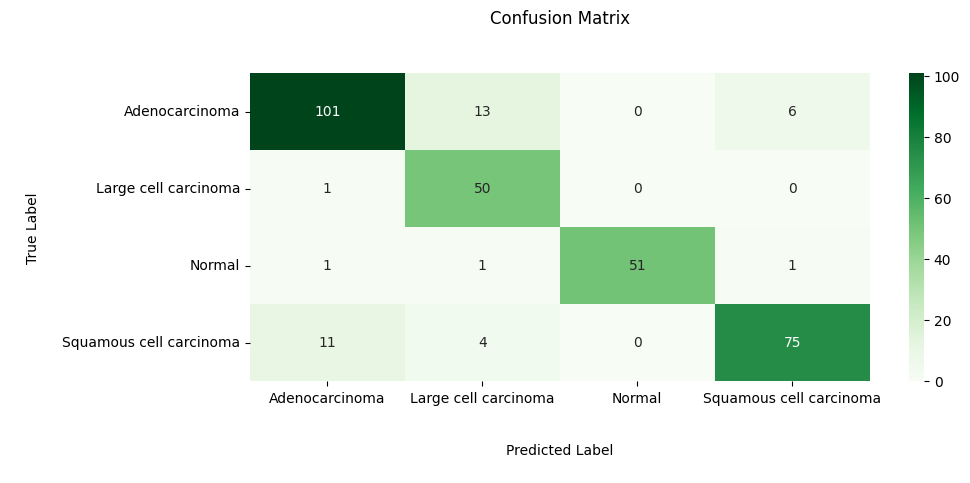

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = df_train['label'].unique(), yticklabels = df_train['label'].unique())
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

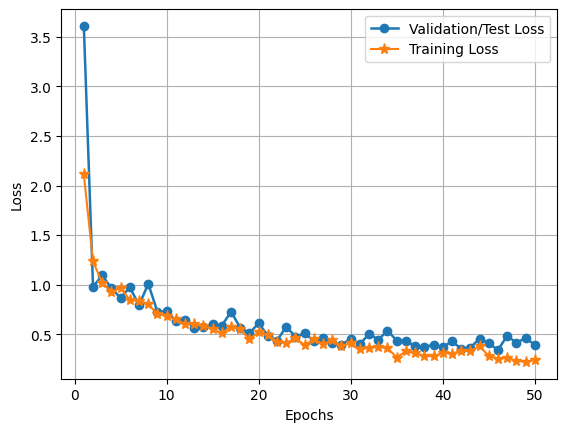

In [ ]:
#Plotting the loss charts

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

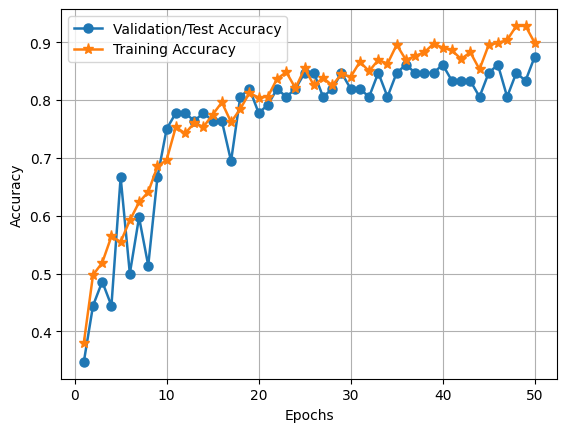

In [ ]:
#Plotting the accuracy charts

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

##3.9. Model Validation

In [ ]:
model1 = keras.models.load_model('my_model.keras')

In [ ]:
test_loss, test_acc = model1.evaluate(validation_generator, steps=len(validation_generator), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

3/3 [==============================] - 1s 113ms/step - loss: 0.3946 - accuracy: 0.8750
Loss: 0.395
Accuracy: 87.500
